In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import timm
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Paths
image_dir = '/kaggle/input/histopathologic-cancer-detection/train/'  
label_file = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'


In [2]:
class PCamDataset(Dataset):
    """Custom Dataset for loading PCam images and labels."""
    
    def __init__(self, labels_df: pd.DataFrame, data_dir: str, transform=None):
        """
        Args:
            labels_df (pd.DataFrame): DataFrame containing image ids and labels.
            data_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.labels_df = labels_df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self) -> int:
        """Returns the total number of images in the dataset."""
        return len(self.labels_df)

    def __getitem__(self, idx: int):
        """Fetches the image and label at the specified index."""
        img_id = self.labels_df.iloc[idx]['id']
        img_path = os.path.join(self.data_dir, img_id + '.tif')
        
        # Load the image with error handling
        img = self.load_image(img_path)
        
        label = self.labels_df.iloc[idx]['label']  # Assuming 'label' column exists
        if self.transform:
            img = self.transform(img)
        return img, label

    def load_image(self, img_path: str) -> Image:
        """Load an image and handle errors."""
        try:
            img = Image.open(img_path).convert('RGB')
            return img
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a blank image as a fallback
            return Image.new('RGB', (96, 96), color=(0, 0, 0))  # Assuming 96x96 size


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms

def load_data(image_dir: str, label_file: str):
    labels = pd.read_csv(label_file)
    labels = labels[~labels['label'].isin([2])]  # Removing any unwanted classes
    labels = labels[~labels['id'].str.contains('black|white')]  # Remove noisy images

    # Split the dataset into training (60%), validation (20%), and test (20%)
    train_labels, temp_labels = train_test_split(labels, test_size=0.4, random_state=42)  # 60% train, 40% temp
    val_labels, test_labels = train_test_split(temp_labels, test_size=0.5, random_state=42)  # 20% val, 20% test

    # Separate the validation and test sets to achieve an 80-20 split
    val_cancer = val_labels[val_labels['label'] == 1]
    val_non_cancer = val_labels[val_labels['label'] == 0].sample(frac=0.2, random_state=42)  # 20% non-cancerous
    val_dataset = pd.concat([val_cancer, val_non_cancer])  # Combine for validation set

    test_cancer = test_labels[test_labels['label'] == 1]
    test_non_cancer = test_labels[test_labels['label'] == 0].sample(frac=0.2, random_state=42)  # 20% non-cancerous
    test_dataset = pd.concat([test_cancer, test_non_cancer])  # Combine for test set

    # Transformations for training data (including random rotation, translation, shearing)
    train_transform = transforms.Compose([
        transforms.CenterCrop(32),
        transforms.RandomRotation(degrees=(0, 360)),  # Random rotation between 0 and 360 degrees
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10),  # Random translation and shear
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.7025, 0.5463, 0.6965], std=[0.2389, 0.2821, 0.2163])
    ])

    # Transformations for validation and test data (no augmentations)
    val_test_transform = transforms.Compose([
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.7025, 0.5463, 0.6965], std=[0.2389, 0.2821, 0.2163])
    ])

    # Create datasets
    train_dataset = PCamDataset(train_labels, image_dir, transform=train_transform)
    val_dataset = PCamDataset(val_dataset, image_dir, transform=val_test_transform)
    test_dataset = PCamDataset(test_dataset, image_dir, transform=val_test_transform)

    return train_dataset, val_dataset, test_dataset


In [4]:
class CustomSwinTransformer(nn.Module):
    def __init__(self, num_classes=2, img_size=32, patch_size=4):
        super(CustomSwinTransformer, self).__init__()
        self.model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=num_classes)
        self.img_size = img_size
        self.patch_size = patch_size

        # Update model input size
        self.model.patch_embed.img_size = (img_size, img_size)
        self.model.patch_embed.patches = (img_size // patch_size, img_size // patch_size)

    def forward(self, x):
        return self.model(x)


In [5]:
from sklearn.metrics import precision_recall_curve, auc
import torch
from tqdm import tqdm
import numpy as np

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.train()
    all_losses = []
    all_accuracies = []

    for epoch in range(num_epochs):
        epoch_losses = []
        epoch_accuracies = []

        running_loss = 0.0
        correct = 0
        total = 0

        with tqdm(total=len(train_loader), desc=f'Training Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step() 

                running_loss += loss.item()
                epoch_losses.append(loss.item())
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                accuracy = (predicted == labels).sum().item() / labels.size(0)
                epoch_accuracies.append(accuracy)

                pbar.update(1)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total
        all_losses.extend(epoch_losses)
        all_accuracies.extend(epoch_accuracies)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        val_loss, val_accuracy, pr_auc = validate_model(model, val_loader, criterion, device)
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation PR AUC: {pr_auc:.4f}')

    return all_losses, all_accuracies


def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store labels and probabilities for PR AUC calculation
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())  # Taking the probability of the positive class (class 1)

    val_loss = running_loss / len(val_loader)
    val_accuracy = correct / total

    # Compute Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    pr_auc = auc(recall, precision)

    return val_loss, val_accuracy, pr_auc


In [6]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(model, data_loader, device):
    model.eval()
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)

            # Store labels and probabilities for the positive class (class 1, cancerous)
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())  # Probabilities for class 1

    # Compute ROC curve and ROC area (AUC)
    fpr, tpr, _ = roc_curve(all_labels, all_outputs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Training Epoch 1/25: 100%|██████████| 4125/4125 [30:38<00:00,  2.24batch/s]


Epoch [1/25], Loss: 0.4225, Accuracy: 0.8129
Validation Loss: 0.4497, Validation Accuracy: 0.7695, Validation PR AUC: 0.9735


Training Epoch 2/25: 100%|██████████| 4125/4125 [15:37<00:00,  4.40batch/s]


Epoch [2/25], Loss: 0.3754, Accuracy: 0.8367
Validation Loss: 0.4393, Validation Accuracy: 0.7903, Validation PR AUC: 0.9767


Training Epoch 3/25: 100%|██████████| 4125/4125 [15:25<00:00,  4.46batch/s]


Epoch [3/25], Loss: 0.3569, Accuracy: 0.8458
Validation Loss: 0.3577, Validation Accuracy: 0.8275, Validation PR AUC: 0.9800


Training Epoch 4/25: 100%|██████████| 4125/4125 [15:35<00:00,  4.41batch/s]


Epoch [4/25], Loss: 0.3448, Accuracy: 0.8530
Validation Loss: 0.5068, Validation Accuracy: 0.7602, Validation PR AUC: 0.9771


Training Epoch 5/25: 100%|██████████| 4125/4125 [15:15<00:00,  4.51batch/s]


Epoch [5/25], Loss: 0.3331, Accuracy: 0.8585
Validation Loss: 0.4555, Validation Accuracy: 0.7902, Validation PR AUC: 0.9815


Training Epoch 6/25: 100%|██████████| 4125/4125 [14:42<00:00,  4.68batch/s]


Epoch [6/25], Loss: 0.3260, Accuracy: 0.8614
Validation Loss: 0.3479, Validation Accuracy: 0.8312, Validation PR AUC: 0.9824


Training Epoch 7/25: 100%|██████████| 4125/4125 [15:14<00:00,  4.51batch/s]


Epoch [7/25], Loss: 0.3178, Accuracy: 0.8651
Validation Loss: 0.3553, Validation Accuracy: 0.8390, Validation PR AUC: 0.9825


Training Epoch 8/25: 100%|██████████| 4125/4125 [15:29<00:00,  4.44batch/s]


Epoch [8/25], Loss: 0.3140, Accuracy: 0.8665
Validation Loss: 0.3182, Validation Accuracy: 0.8551, Validation PR AUC: 0.9846


Training Epoch 9/25: 100%|██████████| 4125/4125 [15:20<00:00,  4.48batch/s]


Epoch [9/25], Loss: 0.3070, Accuracy: 0.8696
Validation Loss: 0.3080, Validation Accuracy: 0.8586, Validation PR AUC: 0.9844


Training Epoch 10/25: 100%|██████████| 4125/4125 [15:33<00:00,  4.42batch/s]


Epoch [10/25], Loss: 0.3020, Accuracy: 0.8719
Validation Loss: 0.3169, Validation Accuracy: 0.8575, Validation PR AUC: 0.9844


Training Epoch 11/25: 100%|██████████| 4125/4125 [15:29<00:00,  4.44batch/s]


Epoch [11/25], Loss: 0.2980, Accuracy: 0.8746
Validation Loss: 0.3047, Validation Accuracy: 0.8607, Validation PR AUC: 0.9849


Training Epoch 12/25: 100%|██████████| 4125/4125 [15:02<00:00,  4.57batch/s]


Epoch [12/25], Loss: 0.2925, Accuracy: 0.8766
Validation Loss: 0.3122, Validation Accuracy: 0.8517, Validation PR AUC: 0.9842


Training Epoch 13/25: 100%|██████████| 4125/4125 [14:42<00:00,  4.67batch/s]


Epoch [13/25], Loss: 0.2909, Accuracy: 0.8774
Validation Loss: 0.2889, Validation Accuracy: 0.8712, Validation PR AUC: 0.9855


Training Epoch 14/25: 100%|██████████| 4125/4125 [14:43<00:00,  4.67batch/s]


Epoch [14/25], Loss: 0.2855, Accuracy: 0.8802
Validation Loss: 0.3062, Validation Accuracy: 0.8627, Validation PR AUC: 0.9864


Training Epoch 15/25: 100%|██████████| 4125/4125 [14:44<00:00,  4.66batch/s]


Epoch [15/25], Loss: 0.2811, Accuracy: 0.8818
Validation Loss: 0.3205, Validation Accuracy: 0.8540, Validation PR AUC: 0.9860


Training Epoch 16/25: 100%|██████████| 4125/4125 [14:20<00:00,  4.79batch/s]


Epoch [16/25], Loss: 0.2784, Accuracy: 0.8825
Validation Loss: 0.3403, Validation Accuracy: 0.8487, Validation PR AUC: 0.9856


Training Epoch 17/25: 100%|██████████| 4125/4125 [14:31<00:00,  4.74batch/s]


Epoch [17/25], Loss: 0.2751, Accuracy: 0.8838
Validation Loss: 0.3179, Validation Accuracy: 0.8642, Validation PR AUC: 0.9864


Training Epoch 18/25: 100%|██████████| 4125/4125 [15:09<00:00,  4.54batch/s]


Epoch [18/25], Loss: 0.2723, Accuracy: 0.8857
Validation Loss: 0.3454, Validation Accuracy: 0.8458, Validation PR AUC: 0.9866


Training Epoch 19/25: 100%|██████████| 4125/4125 [14:31<00:00,  4.73batch/s]


Epoch [19/25], Loss: 0.2703, Accuracy: 0.8870
Validation Loss: 0.3181, Validation Accuracy: 0.8568, Validation PR AUC: 0.9858


Training Epoch 20/25: 100%|██████████| 4125/4125 [13:44<00:00,  5.00batch/s]


Epoch [20/25], Loss: 0.2655, Accuracy: 0.8886
Validation Loss: 0.3745, Validation Accuracy: 0.8291, Validation PR AUC: 0.9862


Training Epoch 21/25: 100%|██████████| 4125/4125 [14:57<00:00,  4.60batch/s]


Epoch [21/25], Loss: 0.2632, Accuracy: 0.8904
Validation Loss: 0.2950, Validation Accuracy: 0.8686, Validation PR AUC: 0.9875


Training Epoch 22/25: 100%|██████████| 4125/4125 [14:58<00:00,  4.59batch/s]


Epoch [22/25], Loss: 0.2616, Accuracy: 0.8908
Validation Loss: 0.2987, Validation Accuracy: 0.8668, Validation PR AUC: 0.9876


Training Epoch 23/25: 100%|██████████| 4125/4125 [14:59<00:00,  4.59batch/s]


Epoch [23/25], Loss: 0.2573, Accuracy: 0.8928
Validation Loss: 0.2912, Validation Accuracy: 0.8672, Validation PR AUC: 0.9879


Training Epoch 24/25: 100%|██████████| 4125/4125 [14:37<00:00,  4.70batch/s]


Epoch [24/25], Loss: 0.2541, Accuracy: 0.8944
Validation Loss: 0.3006, Validation Accuracy: 0.8707, Validation PR AUC: 0.9876


Training Epoch 25/25: 100%|██████████| 4125/4125 [14:08<00:00,  4.86batch/s]


Epoch [25/25], Loss: 0.2514, Accuracy: 0.8950
Validation Loss: 0.3225, Validation Accuracy: 0.8569, Validation PR AUC: 0.9874


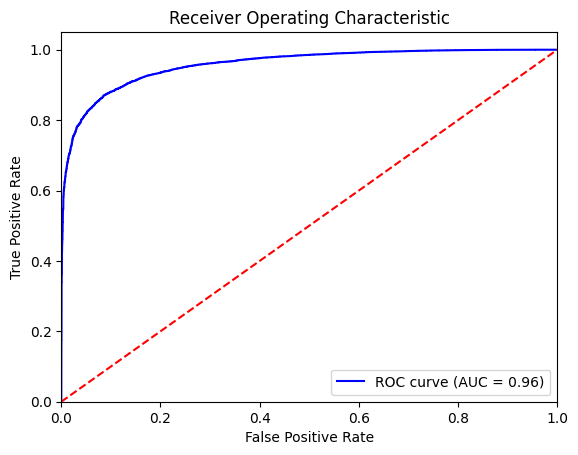

In [7]:
# Load data
train_dataset, val_dataset, test_dataset = load_data(image_dir, label_file)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, criterion, and optimizer
model = CustomSwinTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
num_epochs = 25  # Set the number of epochs
train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs,
    device
)

# Plot ROC curve after training
plot_roc_curve(model, val_loader, device)


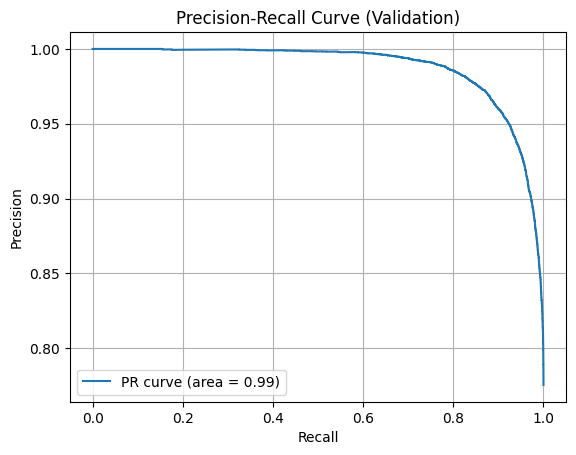

In [8]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

def plot_precision_recall_curve(model, data_loader, device, dataset_name):
    model.eval()
    all_labels = []
    all_outputs = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())
    
    precision, recall, _ = precision_recall_curve(all_labels, all_outputs)
    pr_auc = auc(recall, precision)
    
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ({dataset_name})')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

# Plot for validation data
plot_precision_recall_curve(model, val_loader, device, 'Validation')


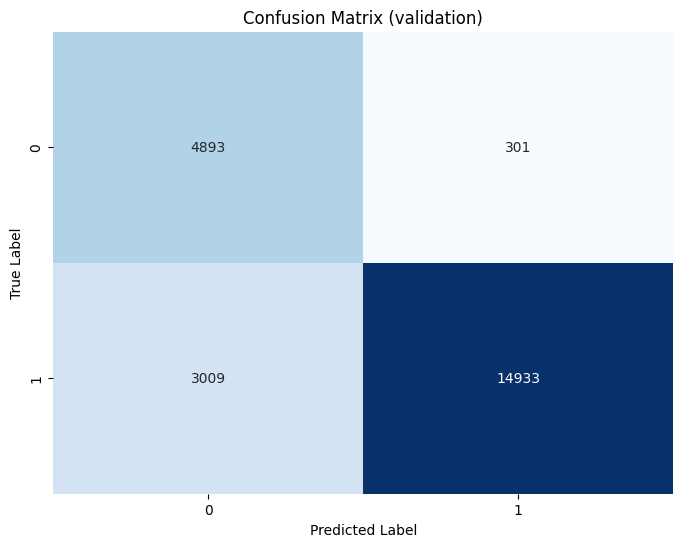

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, data_loader, device, dataset_name):
    model.eval()
    all_labels = []
    all_predictions = []

    # Collect all predictions and true labels
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix ({dataset_name})')
    plt.show()

# Call the function after validation
plot_confusion_matrix(model, val_loader, device, 'validation')


In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

def test_model_with_roc(model, test_loader, criterion, device, num_classes=2):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_probs = []

    # Disable gradient calculation as we're only testing
    with torch.no_grad():
        with tqdm(total=len(test_loader), desc='Testing', unit='batch') as pbar:
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                # Store the predicted probabilities and labels for ROC
                probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Probabilities for the positive class
                all_probs.extend(probs)
                all_labels.extend(labels.cpu().numpy())

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                pbar.update(1)

    # Calculate overall test loss and accuracy
    test_loss = running_loss / len(test_loader)
    test_accuracy = correct / total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    # Generate ROC curve and calculate AUC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return test_loss, test_accuracy, roc_auc


Testing: 100%|██████████| 719/719 [01:58<00:00,  6.04batch/s]


Test Loss: 0.3250, Test Accuracy: 0.8570


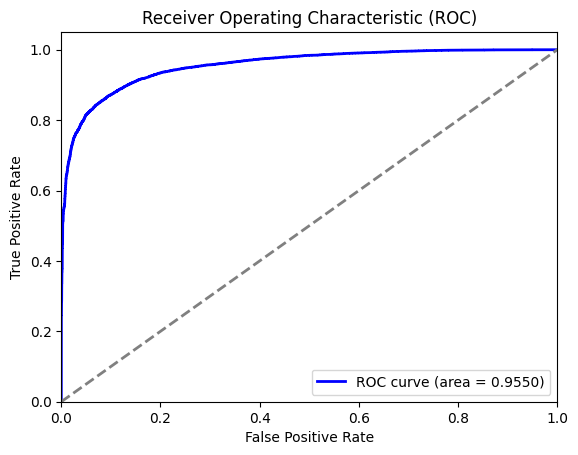

In [22]:
# Test the model and plot ROC curve
test_loss, test_accuracy, test_roc_auc = test_model_with_roc(model, test_loader, criterion, device)


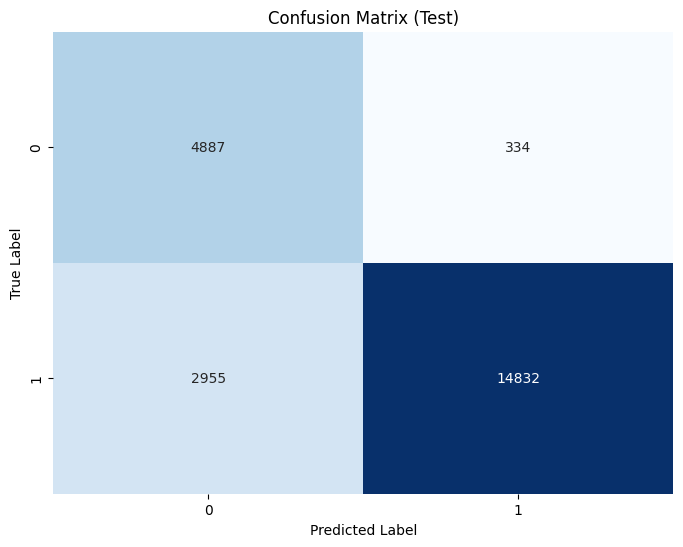

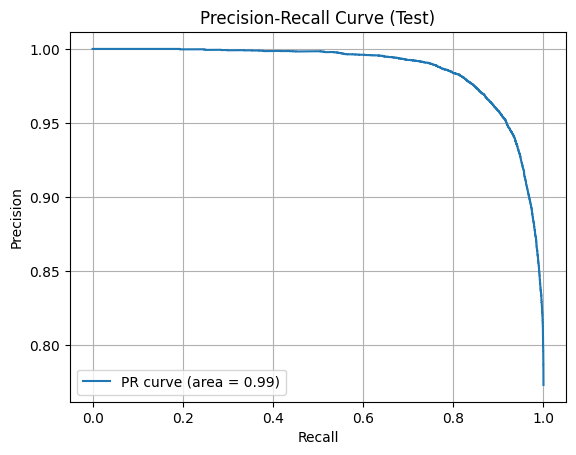

In [25]:
plot_confusion_matrix(model,test_loader,device, 'Test')
plot_precision_recall_curve(model, test_loader, device, 'Test')

In [26]:
# Save model weights to a local path on Kaggle
weights_save_path = '/kaggle/working/swin_transformer_weights_version2.pth'

# Save the model weights (state_dict)
torch.save(model.state_dict(), weights_save_path)

# Download the weights to your local machine
from IPython.display import FileLink
FileLink(weights_save_path)


/kaggle/working/swin_transformer_weights_version2.pth

In [27]:
# Save the entire model to a local path on Kaggle
model_save_path = '/kaggle/working/swin_transformer_model_version2.pth'

# Save the entire model (architecture + weights)
torch.save(model, model_save_path)

# Download the model to your local machine
from IPython.display import FileLink
FileLink(model_save_path)


/kaggle/working/swin_transformer_model_version2.pth

In [28]:
import os
print(os.listdir("/kaggle/working"))


['swin_transformer_model_version2.pth', 'swin_transformer_weights_version2.pth', '.virtual_documents']


In [16]:
!pip install gdown


In [17]:
!gdown --id 'https://drive.google.com/drive/folders/1T4ad6kdlKKnzVQmeS8eMPznx2Qd5v4YL?usp=sharing' --output swin_transformer_weights.pth
!gdown --id 'https://drive.google.com/drive/folders/1T4ad6kdlKKnzVQmeS8eMPznx2Qd5v4YL?usp=sharing' --output swin_transformer_model.pth


/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=https://drive.google.com/drive/folders/1T4ad6kdlKKnzVQmeS8eMPznx2Qd5v4YL?usp=sharing

but Gdown can't. Please check connections and permissions.
/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You